In [1]:
from __future__ import print_function
%matplotlib notebook  

import numpy as np
import cPickle
import matplotlib.pyplot as plt
import caffe

In [2]:
def collage(data):
    images = [img for img in data.transpose(0, 2, 3, 1)]
    side = int(np.ceil(len(images)**0.5))
    for i in range(side**2 - len(images)):
        images.append(images[-1])
    collage = [np.concatenate(images[i::side], axis=0)
               for i in range(side)]
    collage = np.concatenate(collage, axis=1)
    #collage -= collage.min()
    #collage = collage / np.absolute(collage).max() * 256
    return collage
    

## Read data from CIFAR 10

Trn data shape: (80000, 3, 32, 32)
Tst data shape: (20000, 3, 32, 32)


<IPython.core.display.Javascript object>


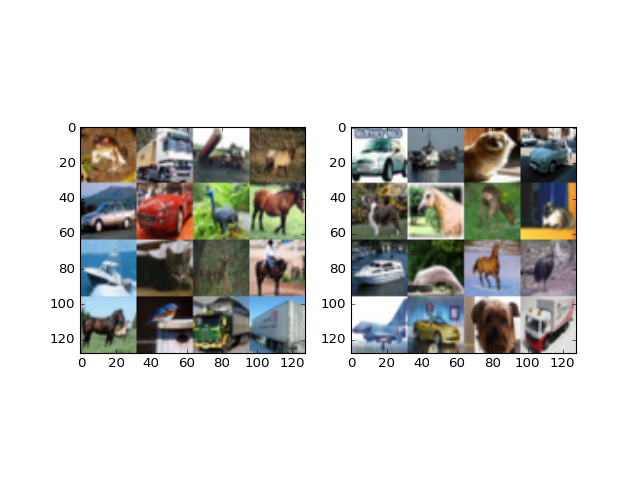

Trn labels shape:  (80000,)
Tst labels shape:  (20000,)
[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]
[1 8 5 1 5 7 4 3 8 2 7 2 0 1 5 9 6 2 0 8]


In [3]:
trnData = []
trnLabels = []
tstData = []
tstLabels = []
for i in range(1,6):
    with open('../data_batch_{}'.format(i)) as f:
        data = cPickle.load(f)
    if i == 5:
        tstData = data['data']
        tstLabels = data['labels']
    else:
        trnData.append(data['data'])
        trnLabels.append(data['labels'])
trnData = np.concatenate(trnData).reshape(-1, 3, 32, 32)
trnData = np.concatenate([trnData[:,:,:,::-1], trnData[:,:,:,:]])
trnLabels = np.concatenate(trnLabels)
trnLabels = np.concatenate([trnLabels, trnLabels])
tstData = tstData.reshape(-1, 3, 32, 32)
tstData = np.concatenate([tstData[:,:,:,::-1], tstData[:,:,:,:]])
tstLabels = np.concatenate([tstLabels, tstLabels])

print('Trn data shape:', trnData.shape)
print('Tst data shape:', tstData.shape)
plt.subplot(1, 2, 1)
img = collage(trnData[:16])
plt.imshow(img)
plt.subplot(1, 2, 2)
img = collage(tstData[:16])
plt.imshow(img)
plt.show()

print('Trn labels shape: ', trnLabels.shape)
print('Tst labels shape: ', tstLabels.shape)
print(trnLabels[:20])
print(tstLabels[:20])

## Normalize data

In [4]:
trnData = trnData.astype(np.float32) / 255 - 0.5
tstData = tstData.astype(np.float32) / 255 - 0.5
'''def zca_whitening(inputs):
    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix
    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition
    epsilon = 0.1                #Whitening constant, it prevents division by zero
    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #ZCA Whitening matrix
    return ZCAMatrix
np.dot(ZCAMatrix, inputs)
'''


'def zca_whitening(inputs):\n    sigma = np.dot(inputs, inputs.T)/inputs.shape[1] #Correlation matrix\n    U,S,V = np.linalg.svd(sigma) #Singular Value Decomposition\n    epsilon = 0.1                #Whitening constant, it prevents division by zero\n    ZCAMatrix = np.dot(np.dot(U, np.diag(1.0/np.sqrt(np.diag(S) + epsilon))), U.T)                     #ZCA Whitening matrix\n    return ZCAMatrix\nnp.dot(ZCAMatrix, inputs)\n'

## Load solver

In [38]:
caffe.set_device(0)
caffe.set_mode_gpu()

solver = caffe.get_solver('net_solver.prototxt')

## Train network

In [39]:
def testNet(testNet, tstData, tstLabels):
    batchSize = 32
    # change batch size
    testNet.blobs['data'].reshape(batchSize, 3, 32, 32)
    testNet.blobs['labels'].reshape(batchSize, 1, 1, 1)
    testNet.reshape()
    loss = 0
    accuracy = 0
    counter = 0
    for i in range(0, tstData.shape[0]-batchSize, batchSize):
        testNet.blobs['data'].data[...] = tstData[i:i + batchSize,:, :, :]
        testNet.blobs['labels'].data[...] = tstLabels[i:i + batchSize].reshape(-1,1,1,1)
        testNet.forward()
        loss += testNet.blobs['loss'].data
        accuracy += testNet.blobs['acc'].data
        counter += 1
    return loss / counter, accuracy / counter

# function whigh updates plots
def pltData(ax, xs, ys, colors, labels, setYlim=False):
    if ax.lines:
        for line, x, y in zip(ax.lines, xs, ys):
            line.set_xdata(x)
            line.set_ydata(y)
    else:
        handles = []
        for x, y, color, label in zip(xs, ys, colors, labels):
            handle, = ax.plot(x, y, color, label=label)
            handles.append(handle)
        plt.legend(handles=handles)
            
    ax.set_xlim(0, np.asarray(xs).max())    
    if setYlim:
        ax.set_ylim(0, np.asarray(ys).max())
    


In [40]:
batchSize = solver.net.blobs['data'].data.shape[0]
print('Blobs:', solver.net.blobs.keys())
testIter = 500

iterVec = []
trnLossVec = []
tstLossVec = []
trnAccVec = []
tstAccVec = []

Blobs: ['data', 'labels', 'labels_labels_0_split_0', 'labels_labels_0_split_1', 'conv1', 'pool1', 'conv2', 'pool2', 'conv3', 'conv4', 'pool5', 'fc6', 'fc7', 'fc8', 'fc8_fc8_0_split_0', 'fc8_fc8_0_split_1', 'acc', 'loss']


<IPython.core.display.Javascript object>


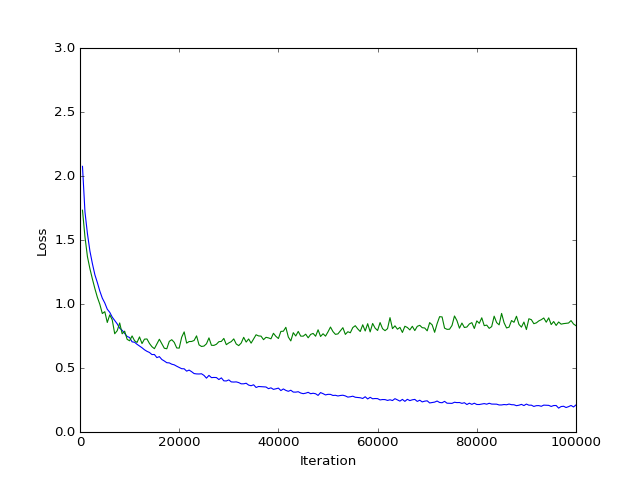

<IPython.core.display.Javascript object>


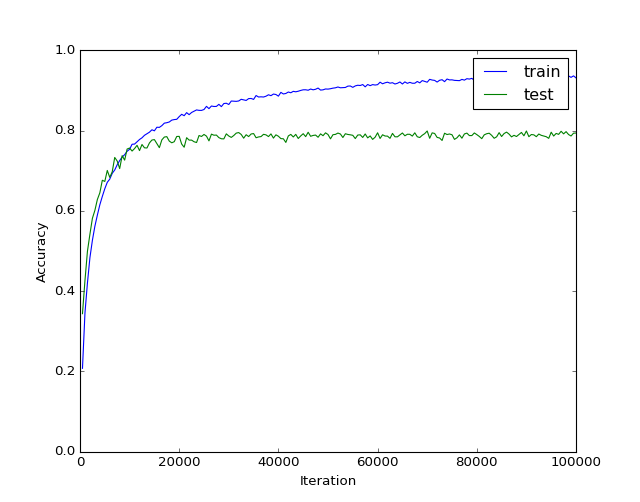

In [41]:
figLoss, axLoss = plt.subplots(1,1)
axLoss.set_xlabel('Iteration')
axLoss.set_ylabel('Loss')
axLoss.set_ylim(0, 3)
figAcc, axAcc = plt.subplots(1,1)
axAcc.set_xlabel('Iteration')
axAcc.set_ylabel('Accuracy')
axAcc.set_ylim(0, 1)
# figLoss.show()
# figAcc.show()

trnLoss = 0
trnAccuracy = 0
trnCounter = 0
for i in range(100000):
    pos = (i * batchSize) % trnData.shape[0]
    solver.net.blobs['data'].data[...] = trnData[pos:pos + batchSize,:, :, :]
    solver.net.blobs['labels'].data[...] = trnLabels[pos:pos + batchSize].reshape(-1,1,1,1)
    solver.step(1)
    trnLoss += solver.net.blobs['loss'].data
    trnAccuracy += solver.net.blobs['acc'].data
    trnCounter += 1
    
    if solver.iter % testIter == 0:
        tstLoss, tstAccuracy = testNet(solver.test_nets[0], tstData, tstLabels)
        iterVec.append(solver.iter)
        trnLossVec.append(trnLoss / trnCounter)
        tstLossVec.append(tstLoss)
        trnAccVec.append(trnAccuracy / trnCounter)
        tstAccVec.append(tstAccuracy)
        pltData(axLoss, [iterVec, iterVec], [trnLossVec, tstLossVec], ['b', 'g'], ['train', 'test'])
        figLoss.canvas.draw()
        pltData(axAcc, [iterVec, iterVec], [trnAccVec, tstAccVec], ['b', 'g'], ['train', 'test'])
        figAcc.canvas.draw()
        trnLoss = 0
        trnAccuracy = 0
        trnCounter = 0


        



## Test network

In [42]:
testNet = solver.test_nets[0]
batchSize = 32
#change batch size
testNet.blobs['data'].reshape(batchSize, 3, 32, 32)
testNet.blobs['labels'].reshape(batchSize, 1, 1, 1)
testNet.reshape()
loss = 0
accuracy = 0
counter = 0
for i in range(0, tstData.shape[0]-batchSize, batchSize):
    testNet.blobs['data'].data[...] = tstData[i:i + batchSize,:, :, :]
    testNet.blobs['labels'].data[...] = tstLabels[i:i + batchSize].reshape(-1,1,1,1)
    testNet.forward()
    loss += testNet.blobs['loss'].data
    accuracy += testNet.blobs['acc'].data
    counter += 1
print('Test loss: ', loss / counter)
print('Test accuracy: ', accuracy / counter)

Test loss:  0.830408582201
Test accuracy:  0.793770032051


## Save and restore and deploy

In [43]:
# save snapshot to file with solver.iter in the name
solver.snapshot()

# save net
solver.net.save('myNet.model')

# load deploy net and compute some class probabilities
batchSize = 16
deployNet = caffe.Net('net_deploy.prototxt', 'myNet.model', caffe.TEST)
deployNet.blobs['data'].reshape(batchSize, 3, 32, 32)
deployNet.reshape()
deployNet.blobs['data'].data[...] = tstData[0:batchSize, :, :, :]
deployNet.forward()
print(tstLabels[0:batchSize])
for prob, label in zip(deployNet.blobs['out'].data, tstLabels):
    print('class: {} prob: {}'.format(label, prob[label]))


[1 8 5 1 5 7 4 3 8 2 7 2 0 1 5 9]
class: 1 prob: 1.0
class: 8 prob: 0.997750818729
class: 5 prob: 0.596641182899
class: 1 prob: 0.99985396862
class: 5 prob: 0.0288947671652
class: 7 prob: 0.997801840305
class: 4 prob: 0.0589174814522
class: 3 prob: 0.417830109596
class: 8 prob: 1.0
class: 2 prob: 0.995085895061
class: 7 prob: 0.154385685921
class: 2 prob: 0.993611633778
class: 0 prob: 0.999497056007
class: 1 prob: 0.999898433685
class: 5 prob: 0.992648005486
class: 9 prob: 0.999742090702


# show filters

In [44]:
filters = deployNet.params['conv1'][0].data
filters = filters - filters.min()
filters = filters / filters.max()
img = collage(filters)
print(filters.shape, img.shape)
plt.imshow(img)
plt.show()

(32, 3, 5, 5) (30, 30, 3)


In [ ]:
print('DONE')

<IPython.core.display.Javascript object>


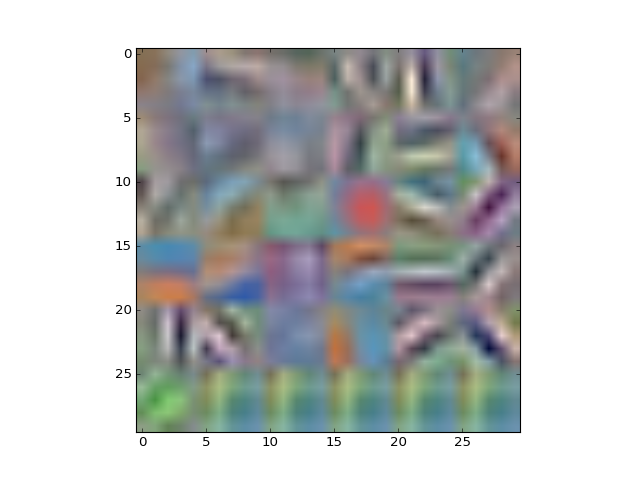

In [45]:
fig, ax = plt.subplots(1,1)
ax.imshow(img)
